In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor



In [2]:
data_url = "https://richardson.byu.edu/220/OnlineNewsPopularity.csv"
data = pd.read_csv(data_url)

print(data.head())

                                                 url   timedelta  \
0  http://mashable.com/2013/01/07/amazon-instant-...       731.0   
1  http://mashable.com/2013/01/07/ap-samsung-spon...       731.0   
2  http://mashable.com/2013/01/07/apple-40-billio...       731.0   
3  http://mashable.com/2013/01/07/astronaut-notre...       731.0   
4   http://mashable.com/2013/01/07/att-u-verse-apps/       731.0   

    n_tokens_title   n_tokens_content   n_unique_tokens   n_non_stop_words  \
0             12.0              219.0          0.663594                1.0   
1              9.0              255.0          0.604743                1.0   
2              9.0              211.0          0.575130                1.0   
3              9.0              531.0          0.503788                1.0   
4             13.0             1072.0          0.415646                1.0   

    n_non_stop_unique_tokens   num_hrefs   num_self_hrefs   num_imgs  ...  \
0                   0.815385         4.0     

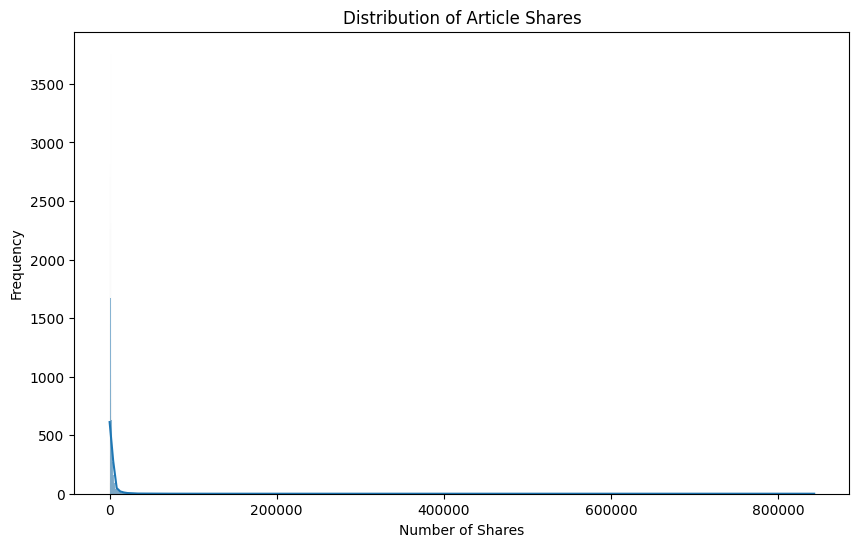

In [3]:
plt.figure(figsize=(10, 6))
sns.histplot(data[' shares'], kde=True)
plt.title('Distribution of Article Shares')
plt.xlabel('Number of Shares')
plt.ylabel('Frequency')
plt.show()

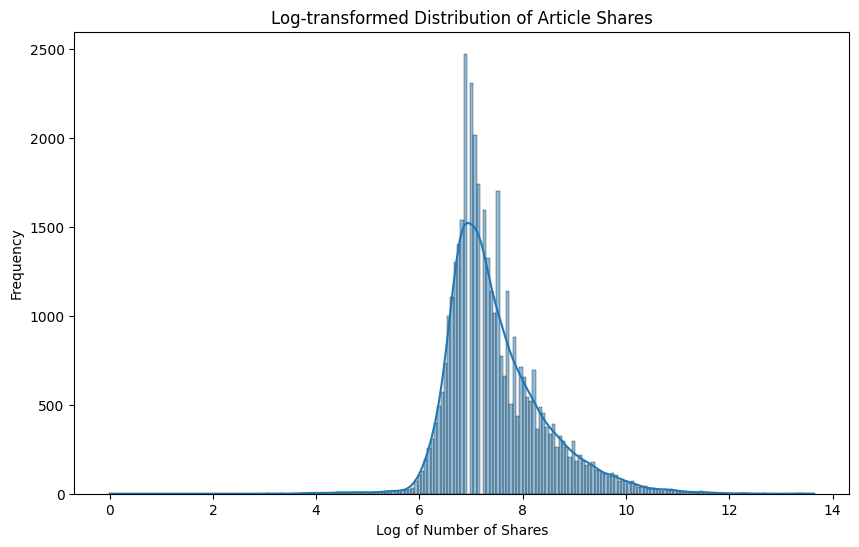

In [5]:
data['log_shares'] = np.log(data[' shares'])

plt.figure(figsize=(10, 6))
sns.histplot(data['log_shares'], kde=True)
plt.title('Log-transformed Distribution of Article Shares')
plt.xlabel('Log of Number of Shares')
plt.ylabel('Frequency')
plt.show()


In [14]:
# Model
X = data.drop(['url', ' shares', 'log_shares'], axis=1)
y = data['log_shares']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             log_shares   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     101.0
Date:                Fri, 15 Dec 2023   Prob (F-statistic):               0.00
Time:                        05:26:53   Log-Likelihood:                -50705.
No. Observations:               39644   AIC:                         1.015e+05
Df Residuals:                   39586   BIC:                         1.020e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [18]:
X = data.drop(['url', ' shares', 'log_shares'], axis=1)
y = data['log_shares']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

train_predictions = tree_reg.predict(X_train)
test_predictions = tree_reg.predict(X_test)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train RMSE: {np.sqrt(train_mse)}')
print(f'Test RMSE: {np.sqrt(test_mse)}')

Train MSE: 3.134052469110752e-33
Test MSE: 1.5020035704463304
Train RMSE: 5.598260863081277e-17
Test RMSE: 1.2255625526452456


In [19]:
tree_reg_pruned = DecisionTreeRegressor(max_depth=5, min_samples_split=20, random_state=42)
tree_reg_pruned.fit(X_train, y_train)

train_predictions_pruned = tree_reg_pruned.predict(X_train)
test_predictions_pruned = tree_reg_pruned.predict(X_test)

train_mse_pruned = mean_squared_error(y_train, train_predictions_pruned)
test_mse_pruned = mean_squared_error(y_test, test_predictions_pruned)

print(f'Pruned Train MSE: {train_mse_pruned}')
print(f'Pruned Test MSE: {test_mse_pruned}')
print(f'Pruned Train RMSE: {np.sqrt(train_mse_pruned)}')
print(f'Pruned Test RMSE: {np.sqrt(test_mse_pruned)}')

Pruned Train MSE: 0.7624679816733493
Pruned Test MSE: 0.7534544806968598
Pruned Train RMSE: 0.8731941259956741
Pruned Test RMSE: 0.8680175578275245


In [20]:
# Convert RMSE back to the original scale of shares
original_scale_train_rmse = np.exp(np.sqrt(train_mse_pruned))
original_scale_test_rmse = np.exp(np.sqrt(test_mse_pruned))

print(f'Original Scale Train RMSE: {original_scale_train_rmse}')
print(f'Original Scale Test RMSE: {original_scale_test_rmse}')


Original Scale Train RMSE: 2.3945471366637254
Original Scale Test RMSE: 2.382183628060067


In [22]:
# Initialize LASSO
lasso = Lasso(alpha=0.01)

lasso.fit(X_train, y_train)

train_predictions = lasso.predict(X_train)
test_predictions = lasso.predict(X_test)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Train MSE: 0.7707485940654535
Test MSE: 0.7536447132764178


In [23]:
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

grid = GridSearchCV(Lasso(), tuned_parameters, cv=n_folds, refit=False)
grid.fit(X_train, y_train)

best_alpha = grid.best_params_['alpha']
print('Best alpha:', best_alpha)

lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train, y_train)

train_predictions_best = lasso_best.predict(X_train)
test_predictions_best = lasso_best.predict(X_test)
train_mse_best = mean_squared_error(y_train, train_predictions_best)
test_mse_best = mean_squared_error(y_test, test_predictions_best)

print(f'Optimized Train MSE: {train_mse_best}')
print(f'Optimized Test MSE: {test_mse_best}')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.454e+03, tolerance: 2.183e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.284e+03, tolerance: 2.202e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.692e+03, tolerance: 2.224e

Best alpha: 0.0009236708571873865
Optimized Train MSE: 0.7591969761941357
Optimized Test MSE: 0.749179307804584


In [25]:
# Scale features
scaler = StandardScaler()

# Create a LASSO model with increased max iterations
lasso = Lasso(alpha=best_alpha, max_iter=10000)

lasso_pipeline = make_pipeline(scaler, lasso)

lasso_pipeline.fit(X_train, y_train)

train_predictions = lasso_pipeline.predict(X_train)
test_predictions = lasso_pipeline.predict(X_test)
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print(f'Scaled and Optimized Train MSE: {train_mse}')
print(f'Scaled and Optimized Test MSE: {test_mse}')

Scaled and Optimized Train MSE: 0.7584662710159739
Scaled and Optimized Test MSE: 0.7490007185557922


**Coefficients (coef) and their Significance (P>|t|):**

- Each coefficient represents the change in the log-transformed number of shares for a one-unit change in the predictor, holding all other predictors constant.

- The P>|t| column gives the p-value for each predictor. A p-value less than 0.05 typically suggests that the predictor is statistically significant.

**Significant Predictors:**

- **Positive Coefficients:** Indicate a positive relationship with the log-transformed number of shares.

- **Negative Coefficients:** Indicate a negative relationship. For instance, data_channel_is_entertainment has a coefficient of -0.1797, suggesting entertainment articles might have fewer shares compared to other categories.

**Insignificant Predictors:**

- Predictors with high p-values, like > 0.05, are less likely to be meaningful in the model. These might be candidates for removal in model refinement.

**Model Fit:**

- The R-squared value of 0.127 suggests that about 12.7% of the variance in the log-transformed number of shares is explained by the model, which is moderate.

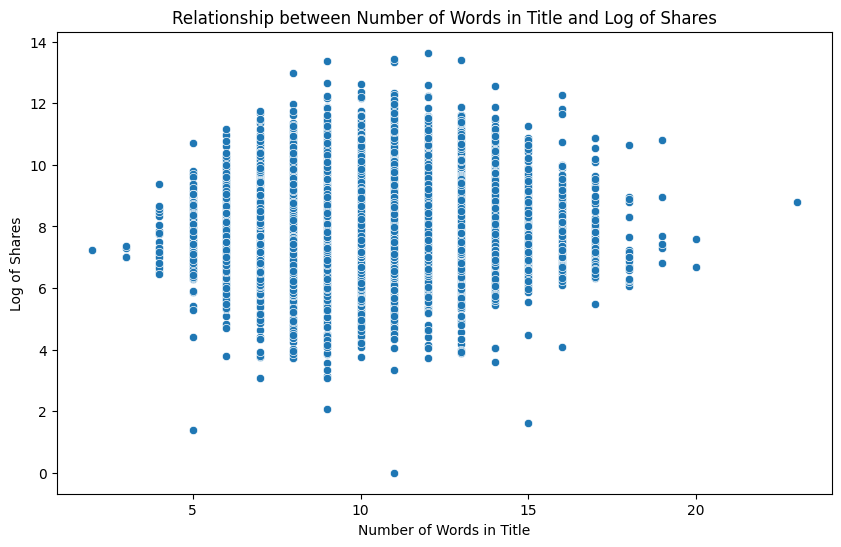

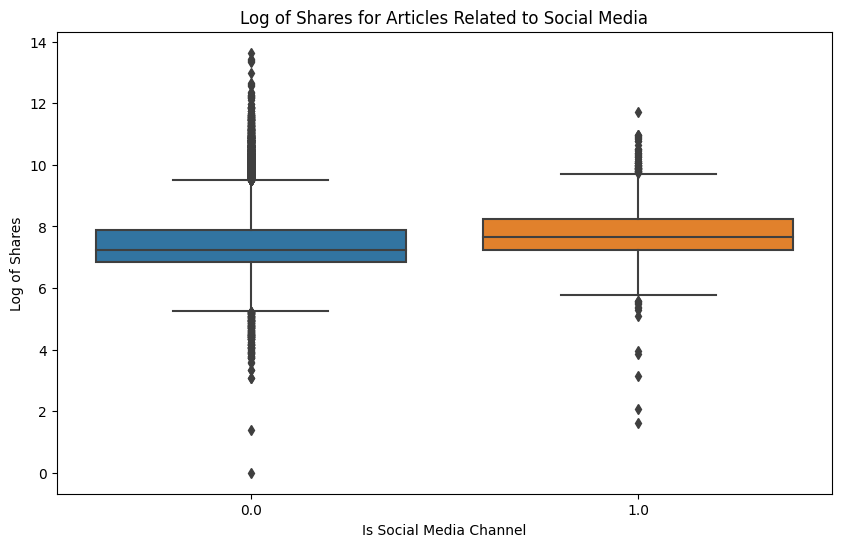

In [30]:
data.columns = data.columns.str.strip()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='n_tokens_title', y='log_shares', data=data)
plt.title('Relationship between Number of Words in Title and Log of Shares')
plt.xlabel('Number of Words in Title')
plt.ylabel('Log of Shares')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='data_channel_is_socmed', y='log_shares', data=data)
plt.title('Log of Shares for Articles Related to Social Media')
plt.xlabel('Is Social Media Channel')
plt.ylabel('Log of Shares')
plt.show()


In [31]:
# Initialize the Random Forest
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

rf_reg.fit(X_train, y_train)

rf_train_predictions = rf_reg.predict(X_train)
rf_test_predictions = rf_reg.predict(X_test)

rf_train_mse = mean_squared_error(y_train, rf_train_predictions)
rf_test_mse = mean_squared_error(y_test, rf_test_predictions)

print(f'Random Forest Train MSE: {rf_train_mse}')
print(f'Random Forest Test MSE: {rf_test_mse}')

Random Forest Train MSE: 0.1033001195103987
Random Forest Test MSE: 0.7181038183402001


In [33]:
# This takes too long but I'll leave it here.
# hyperparameters to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

best_rf = grid_search.best_estimator_

best_rf_train_predictions = best_rf.predict(X_train)
best_rf_test_predictions = best_rf.predict(X_test)

best_rf_train_mse = mean_squared_error(y_train, best_rf_train_predictions)
best_rf_test_mse = mean_squared_error(y_test, best_rf_test_predictions)

print(f'Tuned Random Forest Train MSE: {best_rf_train_mse}')
print(f'Tuned Random Forest Test MSE: {best_rf_test_mse}')


Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyboardInterrupt: ignored